Iñigo Martin Melero

## Participante 22

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_22_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


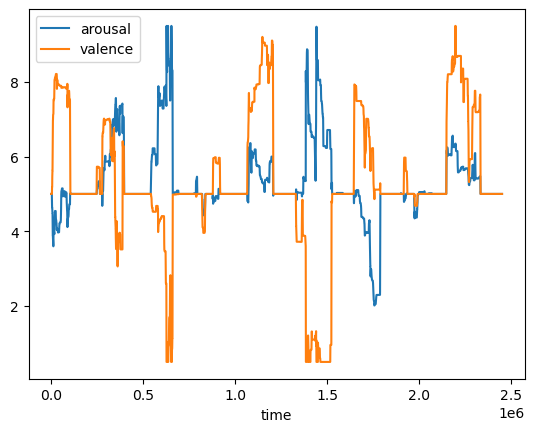

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_22_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.909  36.515  11.729  33.989  22.886     7.247     7.698   
1              1  0.827  36.670  11.753  33.998  22.890     7.288     7.821   
2              2  0.748  36.767  11.698  34.008  22.886     7.288     7.781   
3              3  0.679  36.375  11.667  33.979  22.883     7.288     7.659   
4              4  0.617  36.428  11.705  33.998  22.886     7.207     7.658   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.659  36.103   7.385  33.021  22.490     5.482     6.139   
2451580  2451580  0.659  36.263   7.314  33.021  22.494     5.522     6.138   
2451581  2451581  0.649  36.379   7.353  33.002  22.490     5.482     6.098   
2451582  2451582  0.649  36.467   7.392  33.030  22.494     5.522     6.138   
2451583  2451583  0.655  36.247   7.346  33.011  22.490     5.563     6.219   

         emg_trap  video  
0          12.297     10

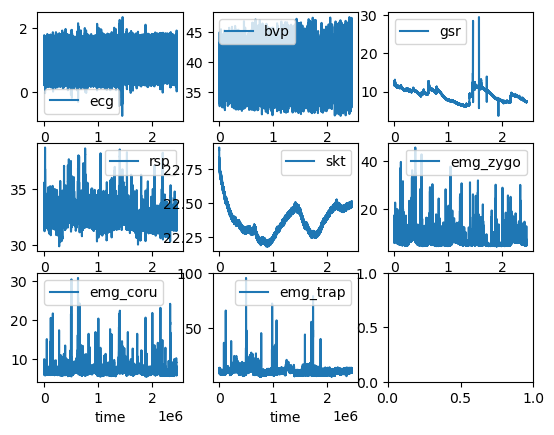

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

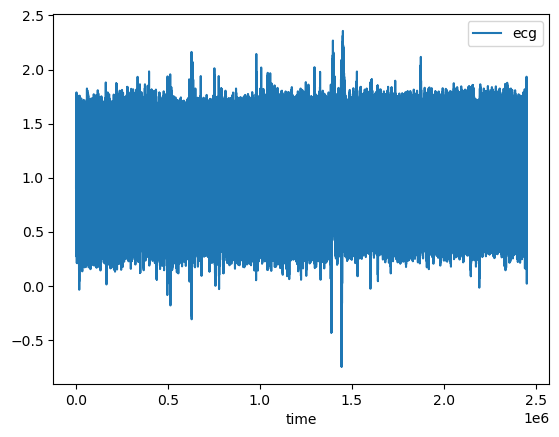

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

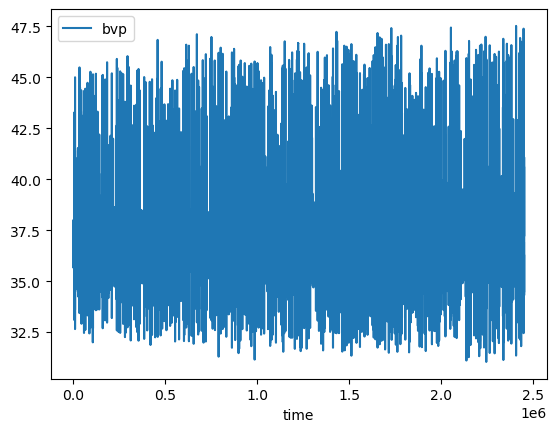

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

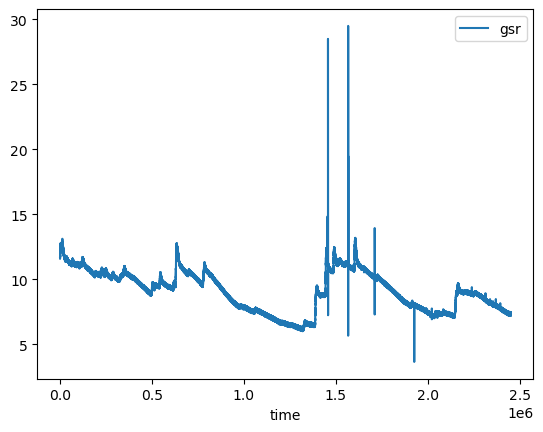

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

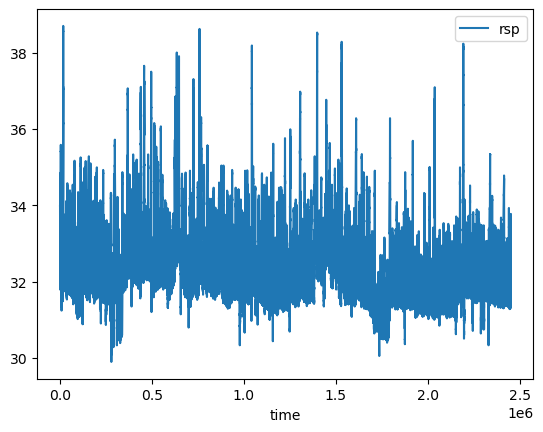

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

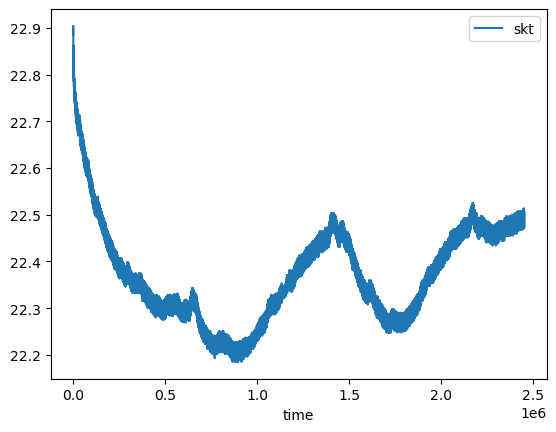

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

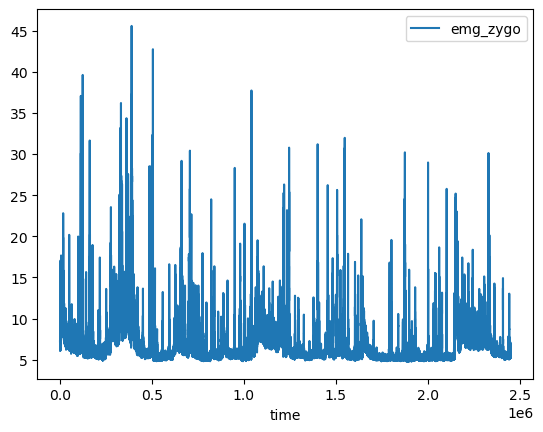

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

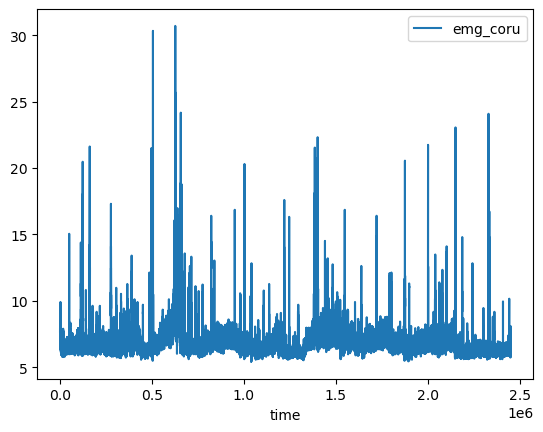

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

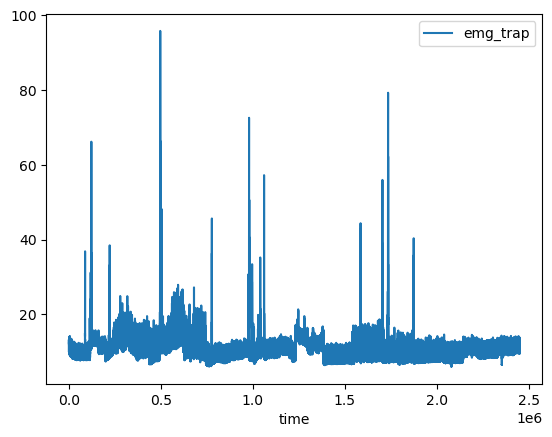

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

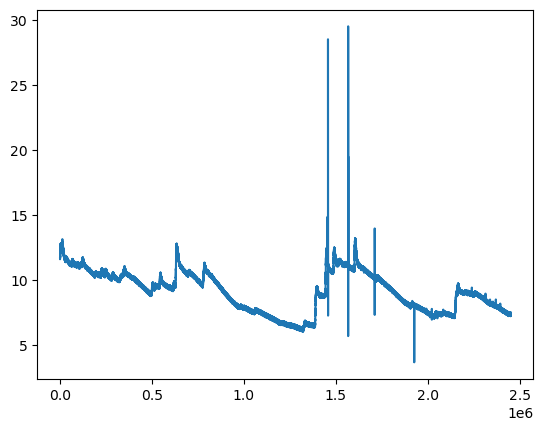

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

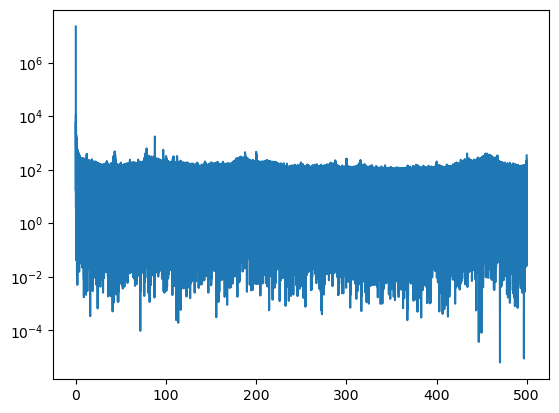

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

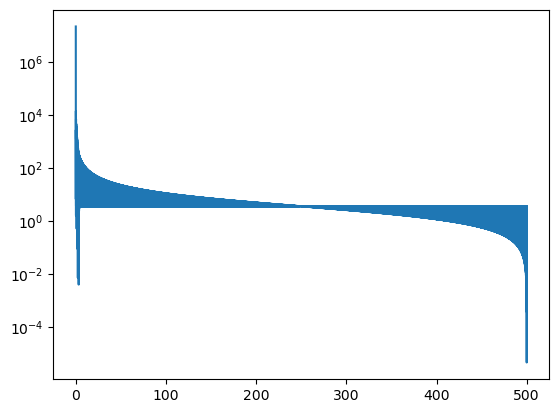

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

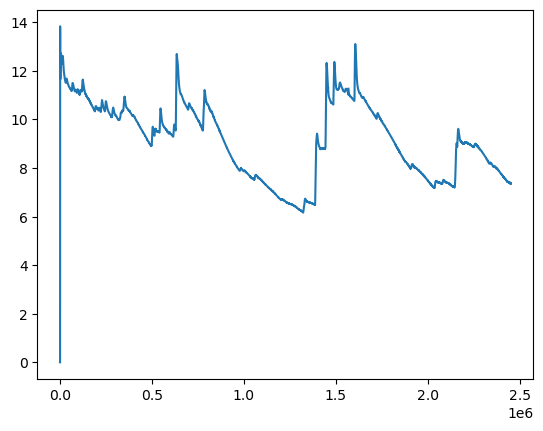

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0        0.000
1        0.000
2        0.000
3        0.000
4        0.000
...        ...
2451579  7.374
2451580  7.374
2451581  7.374
2451582  7.374
2451583  7.374

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

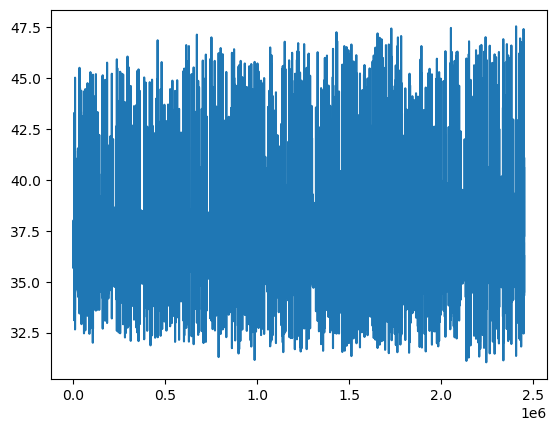

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

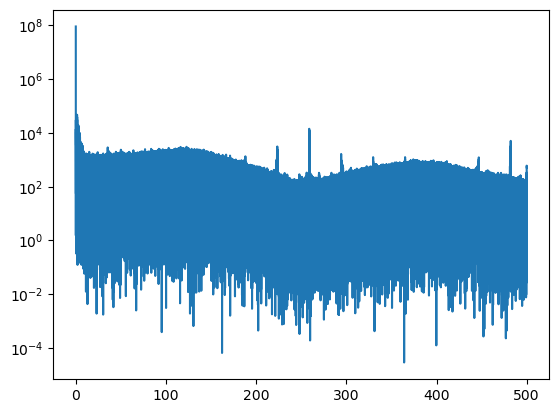

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

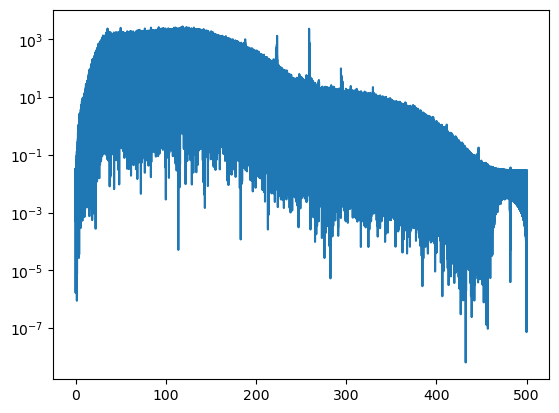

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

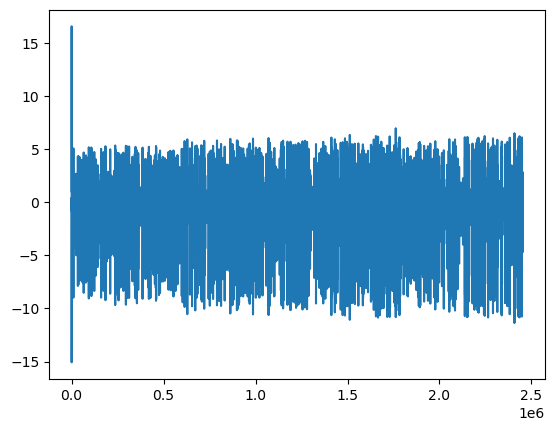

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.015
1        42.665
2        50.344
3        53.527
4        46.256
...         ...
2451579  36.993
2451580  37.057
2451581  37.038
2451582  36.991
2451583  37.019

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

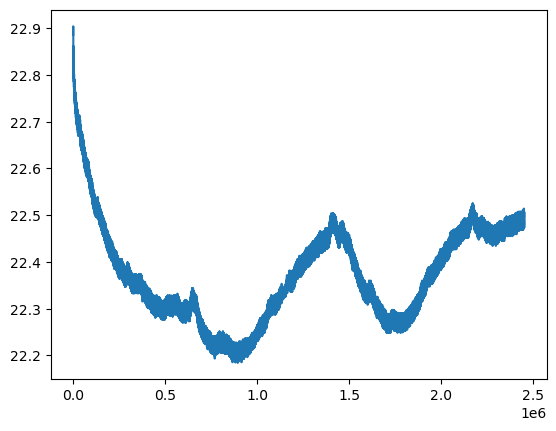

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

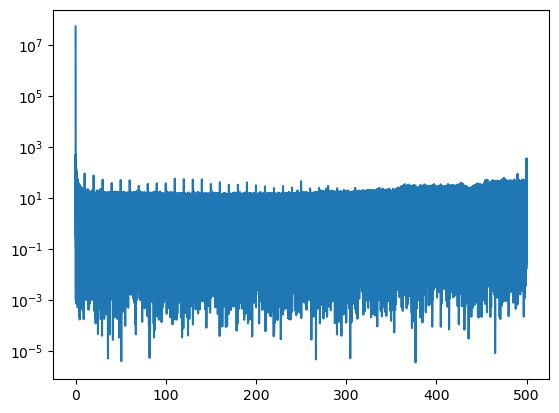

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

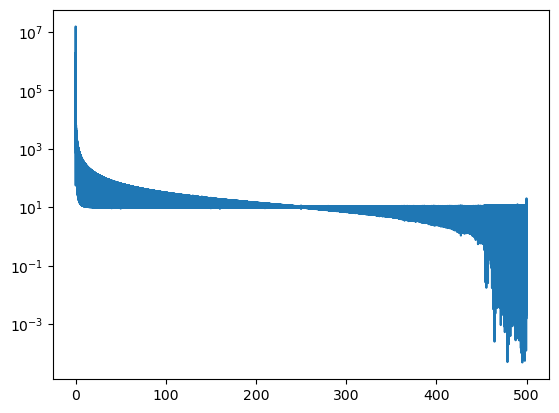

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

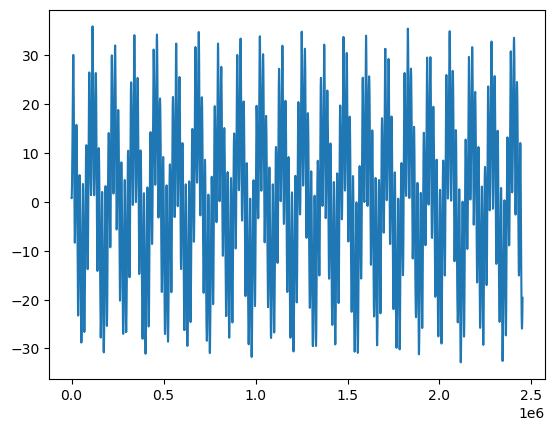

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.733
1        40.734
2        40.733
3        40.733
4        40.733
...         ...
2451579  20.341
2451580  20.345
2451581  20.349
2451582  20.352
2451583  20.356

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.909  33.989     7.247     7.698    12.297     10
1              1  0.827  33.998     7.288     7.821    12.421     10
2              2  0.748  34.008     7.288     7.781    12.503     10
3              3  0.679  33.979     7.288     7.659    12.382     10
4              4  0.617  33.998     7.207     7.658    12.381     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.659  33.021     5.482     6.139    12.217     12
2451580  2451580  0.659  33.021     5.522     6.138    12.176     12
2451581  2451581  0.649  33.002     5.482     6.098    12.053     12
2451582  2451582  0.649  33.030     5.522     6.138    12.093     12
2451583  2451583  0.655  33.011     5.563     6.219    12.052     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.909  33.989     7.247     7.698    12.297     10  38.015   
1              1  0.827  33.998     7.288     7.821    12.421     10  42.665   
2              2  0.748  34.008     7.288     7.781    12.503     10  50.344   
3              3  0.679  33.979     7.288     7.659    12.382     10  53.527   
4              4  0.617  33.998     7.207     7.658    12.381     10  46.256   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.659  33.021     5.482     6.139    12.217     12  36.993   
2451580  2451580  0.659  33.021     5.522     6.138    12.176     12  37.057   
2451581  2451581  0.649  33.002     5.482     6.098    12.053     12  37.038   
2451582  2451582  0.649  33.030     5.522     6.138    12.093     12  36.991   
2451583  2451583  0.655  33.011     5.563     6.219    12.052     12  37.019   

           gsr     skt  
0        0.000  40.733  
1        0.000  40.734  
2        0.000  40.733  
3        0.000  40.733  
4        0.000  40.733  
...        ...     ...  
2451579  7.374  20.341  
2451580  7.374  20.345  
2451581  7.374  20.349  
2451582  7.374  20.352  
2451583  7.374  20.356  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.475193  0.615188  0.623166  0.789935  0.199583  0.014028   
221502    221502  0.481314  0.616465  0.623166  0.789858  0.201784  0.018001   
221503    221503  0.480348  0.618741  0.623166  0.789780  0.200626  0.014053   
221504    221504  0.486791  0.617409  0.623166  0.789702  0.200626  0.016996   
221505    221505  0.475193  0.614800  0.623166  0.789624  0.199583  0.018026   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.528995  0.619407  0.293041  0.345944  0.369860  0.162060   
2331580  2331580  0.524807  0.619685  0.293041  0.346022  0.367775  0.157082   
2331581  2331581  0.528028  0.619463  0.293041  0.346099  0.368817  0.155021   
2331582  2331582  0.528995  0.621461  0.293041  0.346193  0.369976  0.156002   
2331583  2331583  0.516430  0.622571  0.293041  0.346271  0.364416  0.150018   

         emg_coru  emg_trap  video  
221501   0.030958  0.138453      2  
221502   0.034181  0.153093      2  
221503   0.030958  0.163273      2  
221504   0.034181  0.175086      2  
221505   0.032589  0.185253      2  
...           ...       ...    ...  
2331579  0.022721  0.039954      1  
2331580  0.019538  0.038856      1  
2331581  0.019498  0.039968      1  
2331582  0.025984  0.041655      1  
2331583  0.016315  0.039433      1  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.475193  0.615188  0.623166  0.199583  0.789935  0.014028   
221502    221502  0.481314  0.616465  0.623166  0.201784  0.789858  0.018001   
221503    221503  0.480348  0.618741  0.623166  0.200626  0.789780  0.014053   
221504    221504  0.486791  0.617409  0.623166  0.200626  0.789702  0.016996   
221505    221505  0.475193  0.614800  0.623166  0.199583  0.789624  0.018026   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.528995  0.619407  0.293041  0.369860  0.345944  0.162060   
2331580  2331580  0.524807  0.619685  0.293041  0.367775  0.346022  0.157082   
2331581  2331581  0.528028  0.619463  0.293041  0.368817  0.346099  0.155021   
2331582  2331582  0.528995  0.621461  0.293041  0.369976  0.346193  0.156002   
2331583  2331583  0.516430  0.622571  0.293041  0.364416  0.346271  0.150018   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.464562  0.617853  0.623166  0.199583  0.788458  0.034188  0.035892   
221540   0.471005  0.608027  0.623166  0.202826  0.786902  0.034163  0.037484   
221560   0.471972  0.613079  0.623166  0.202942  0.785347  0.037155  0.030958   
221580   0.494201  0.616743  0.623166  0.202942  0.783775  0.036199  0.032629   
221600   0.535438  0.610858  0.623166  0.201784  0.782204  0.037180  0.042378   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.516430  0.612857  0.293199  0.357581  0.339255  0.143912  0.022761   
2331520  0.513209  0.617797  0.293199  0.357581  0.340950  0.119730  0.022721   
2331540  0.502577  0.616354  0.293199  0.359898  0.342646  0.138909  0.019498   
2331560  0.505799  0.616520  0.293199  0.369860  0.344342  0.141852  0.029247   
2331580  0.524807  0.619685  0.293041  0.367775  0.346022  0.157082  0.019538   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.464562  0.617853  0.623166  0.199583  0.788458  0.034188  0.035892   
1      0.471005  0.608027  0.623166  0.202826  0.786902  0.034163  0.037484   
2      0.471972  0.613079  0.623166  0.202942  0.785347  0.037155  0.030958   
3      0.494201  0.616743  0.623166  0.202942  0.783775  0.036199  0.032629   
4      0.535438  0.610858  0.623166  0.201784  0.782204  0.037180  0.042378   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.516430  0.612857  0.293199  0.357581  0.339255  0.143912  0.022761   
63500  0.513209  0.617797  0.293199  0.357581  0.340950  0.119730  0.022721   
63501  0.502577  0.616354  0.293199  0.359898  0.342646  0.138909  0.019498   
63502  0.505799  0.616520  0.293199  0.369860  0.344342  0.141852  0.029247   
63503  0.524807  0.619685  0.293041  0.367775  0.346022  0.157082  0.019538   

       emg_trap  valence  arousal  
0      0.291189    5.000    5.000  
1      0.282367    5.000    5.000  
2      0.279362    5.000    5.000  
3      0.214203    5.000    5.000  
4      0.100296    5.000    5.000  
...         ...      ...      ...  
63499  0.037169    7.613    5.467  
63500  0.038843    7.614    5.467  
63501  0.040530    7.617    5.467  
63502  0.040503    7.620    5.467  
63503  0.038856    7.622    5.467  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.464562  0.617853  0.623166  0.199583  0.788458  0.034188  0.035892   
1      0.471005  0.608027  0.623166  0.202826  0.786902  0.034163  0.037484   
2      0.471972  0.613079  0.623166  0.202942  0.785347  0.037155  0.030958   
3      0.494201  0.616743  0.623166  0.202942  0.783775  0.036199  0.032629   
4      0.535438  0.610858  0.623166  0.201784  0.782204  0.037180  0.042378   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.508054  0.615799  0.293356  0.344145  0.332457  0.214470  0.026063   
63496  0.512242  0.619407  0.293356  0.348662  0.334168  0.175181  0.024432   
63497  0.517397  0.616632  0.293356  0.346461  0.335864  0.135941  0.017946   
63498  0.521585  0.614189  0.293356  0.355381  0.337559  0.136898  0.022801   
63499  0.516430  0.612857  0.293199  0.357581  0.339255  0.143912  0.022761   

       emg_trap  valence  arousal  
0      0.291189    5.000    5.000  
1      0.282367    5.000    5.000  
2      0.279362    5.000    5.000  
3      0.214203    5.000    5.000  
4      0.100296    5.000    5.000  
...         ...      ...      ...  
63495  0.036620    7.605    5.467  
63496  0.039419    7.608    5.467  
63497  0.040009    7.610    5.467  
63498  0.041655    7.612    5.467  
63499  0.037169    7.613    5.467  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.464562  0.617853  0.623166  0.199583  0.788458  0.034188  0.035892   
 1   0.471005  0.608027  0.623166  0.202826  0.786902  0.034163  0.037484   
 2   0.471972  0.613079  0.623166  0.202942  0.785347  0.037155  0.030958   
 3   0.494201  0.616743  0.623166  0.202942  0.783775  0.036199  0.032629   
 4   0.535438  0.610858  0.623166  0.201784  0.782204  0.037180  0.042378   
 5   0.441366  0.616243  0.623323  0.198425  0.780633  0.037180  0.042418   
 6   0.416881  0.614633  0.623323  0.195065  0.779062  0.031171  0.035852   
 7   0.442332  0.617020  0.623481  0.192749  0.777491  0.029111  0.039115   
 8   0.449742  0.612801  0.623481  0.191590  0.775920  0.027075  0.042338   
 9   0.476160  0.617409  0.623639  0.193791  0.774349  0.027051  0.048784   
 10  0.623389  0.619296  0.623639  0.189390  0.772762  0.019031  0.043970   
 11  0.374678  0.617409  0.623797  0.186030  0.771175  0.018001  0.045601   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.464562  0.617853  0.623166  0.199583  0.788458  0.034188  0.035892   
1     0.492912  0.618186  0.624744  0.122090  0.748915  0.032103  0.040707   
2     0.464562  0.614689  0.630267  0.270126  0.709139  0.038161  0.040707   
3     0.639175  0.611191  0.637999  0.357581  0.670483  0.022097  0.039115   
4     0.535438  0.615965  0.646047  0.309394  0.634098  0.014028  0.039155   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.464562  0.605973  0.298248  0.174794  0.150906  0.094617  0.011380   
2536  0.473905  0.620961  0.296986  0.165759  0.181660  0.470141  0.462298   
2537  0.509021  0.619851  0.295881  0.070543  0.217282  0.349332  0.334885   
2538  0.475193  0.615466  0.296355  0.155798  0.256670  0.198357  0.205841   
2539  0.480348  0.619407  0.294303  0.266767  0.298421  0.166107  0.075126   

             8         9        10  ...       193       194       195  \
0     0.291189  0.471005  0.608027  ...  0.476160  0.604308  0.624744   
1     0.047857  0.468750  0.618186  ...  0.452964  0.612135  0.629951   
2     0.038843  0.465528  0.615577  ...  0.446521  0.620517  0.637683   
3     0.035467  0.473260  0.617020  ...  0.501611  0.616687  0.645731   
4     0.032668  0.472938  0.615910  ...  0.524807  0.621406  0.652044   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.037731  0.461340  0.621517  ...  0.498389  0.609193  0.296986   
2536  0.038829  0.457474  0.614189  ...  0.500322  0.610525  0.296039   
2537  0.039954  0.503544  0.616409  ...  0.470039  0.618630  0.296355   
2538  0.069288  0.486791  0.618519  ...  0.490013  0.616909  0.294303   
2539  0.038843  0.472938  0.617131  ...  0.516430  0.612857  0.293199   

           196       197       198       199       200  valence  arousal  
0     0.124406  0.750502  0.037131  0.035812  0.048419  5.00000  5.00000  
1     0.266767  0.710710  0.035144  0.045601  0.042218  5.00000  5.00000  
2     0.354222  0.671992  0.019056  0.037523  0.040558  5.00000  5.00000  
3     0.316113  0.635498  0.018026  0.045641  0.034342  5.00000  5.00000  
4     0.236534  0.602147  0.025089  0.027695  0.033780  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.164833  0.180322  0.347370  0.359476  0.038856  7.23500  5.45100  
2536  0.064867  0.215774  0.351392  0.419800  0.038266  7.35640  5.45284  
2537  0.151396  0.255036  0.280956  0.245036  0.089032  7.58440  5.46668  
2538  0.262365  0.296726  0.189283  0.089770  0.036592  7.58952  5.46700  
2539  0.357581  0.339255  0.143912  0.022761  0.037169  7.59980  5.46700  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.464562  0.617853  0.623166  0.199583  0.788458  0.034188  0.035892   
1     0.492912  0.618186  0.624744  0.122090  0.748915  0.032103  0.040707   
2     0.464562  0.614689  0.630267  0.270126  0.709139  0.038161  0.040707   
3     0.639175  0.611191  0.637999  0.357581  0.670483  0.022097  0.039115   
4     0.535438  0.615965  0.646047  0.309394  0.634098  0.014028  0.039155   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.464562  0.605973  0.298248  0.174794  0.150906  0.094617  0.011380   
2536  0.473905  0.620961  0.296986  0.165759  0.181660  0.470141  0.462298   
2537  0.509021  0.619851  0.295881  0.070543  0.217282  0.349332  0.334885   
2538  0.475193  0.615466  0.296355  0.155798  0.256670  0.198357  0.205841   
2539  0.480348  0.619407  0.294303  0.266767  0.298421  0.166107  0.075126   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub22.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.464562  0.617853  0.623166  0.199583  0.788458  0.034188  0.035892   
1     0.492912  0.618186  0.624744  0.122090  0.748915  0.032103  0.040707   
2     0.464562  0.614689  0.630267  0.270126  0.709139  0.038161  0.040707   
3     0.639175  0.611191  0.637999  0.357581  0.670483  0.022097  0.039115   
4     0.535438  0.615965  0.646047  0.309394  0.634098  0.014028  0.039155   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.464562  0.605973  0.298248  0.174794  0.150906  0.094617  0.011380   
2536  0.473905  0.620961  0.296986  0.165759  0.181660  0.470141  0.462298   
2537  0.509021  0.619851  0.295881  0.070543  0.217282  0.349332  0.334885   
2538  0.475193  0.615466  0.296355  0.155798  0.256670  0.198357  0.205841   
2539  0.480348  0.619407  0.294303  0.266767  0.298421  0.166107  0.075126   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub22.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.464562  0.617853  0.623166  0.199583  0.788458  0.034188  0.035892   
1     0.492912  0.618186  0.624744  0.122090  0.748915  0.032103  0.040707   
2     0.464562  0.614689  0.630267  0.270126  0.709139  0.038161  0.040707   
3     0.639175  0.611191  0.637999  0.357581  0.670483  0.022097  0.039115   
4     0.535438  0.615965  0.646047  0.309394  0.634098  0.014028  0.039155   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.464562  0.605973  0.298248  0.174794  0.150906  0.094617  0.011380   
2536  0.473905  0.620961  0.296986  0.165759  0.181660  0.470141  0.462298   
2537  0.509021  0.619851  0.295881  0.070543  0.217282  0.349332  0.334885   
2538  0.475193  0.615466  0.296355  0.155798  0.256670  0.198357  0.205841   
2539  0.480348  0.619407  0.294303  0.266767  0.298421  0.166107  0.075126   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub22.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.464562  0.617853  0.623166  0.199583  0.788458  0.034188  0.035892   
1     0.492912  0.618186  0.624744  0.122090  0.748915  0.032103  0.040707   
2     0.464562  0.614689  0.630267  0.270126  0.709139  0.038161  0.040707   
3     0.639175  0.611191  0.637999  0.357581  0.670483  0.022097  0.039115   
4     0.535438  0.615965  0.646047  0.309394  0.634098  0.014028  0.039155   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.464562  0.605973  0.298248  0.174794  0.150906  0.094617  0.011380   
2536  0.473905  0.620961  0.296986  0.165759  0.181660  0.470141  0.462298   
2537  0.509021  0.619851  0.295881  0.070543  0.217282  0.349332  0.334885   
2538  0.475193  0.615466  0.296355  0.155798  0.256670  0.198357  0.205841   
2539  0.480348  0.619407  0.294303  0.266767  0.298421  0.166107  0.075126   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub22.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.464562  0.617853  0.623166  0.199583  0.788458  0.034188  0.035892   
1     0.492912  0.618186  0.624744  0.122090  0.748915  0.032103  0.040707   
2     0.464562  0.614689  0.630267  0.270126  0.709139  0.038161  0.040707   
3     0.639175  0.611191  0.637999  0.357581  0.670483  0.022097  0.039115   
4     0.535438  0.615965  0.646047  0.309394  0.634098  0.014028  0.039155   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.464562  0.605973  0.298248  0.174794  0.150906  0.094617  0.011380   
2536  0.473905  0.620961  0.296986  0.165759  0.181660  0.470141  0.462298   
2537  0.509021  0.619851  0.295881  0.070543  0.217282  0.349332  0.334885   
2538  0.475193  0.615466  0.296355  0.155798  0.256670  0.198357  0.205841   
2539  0.480348  0.619407  0.294303  0.266767  0.298421  0.166107  0.075126   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub22.csv', index=False)